In [4]:
# 1024x1024 RGB
from pynq import Overlay
overlay = Overlay("hist1024.xsa")
overlay?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff592ea3e0>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay hist1024.xsa. The following
attributes are available on this overlay:

IP Blocks
----------
doHist_0             : pynq.overlay.DefaultIP
axi_dma_0            : pynq.lib.dma.DMA
zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP

Hierarchies
-----------
None

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time
protection of bindings.

Our definition of overlay is: "post-bitstream configurable design".
Hence, this class must expose configurability through content discovery
and runtime protection.

The overlay class exposes the IP and hierarchies as attr

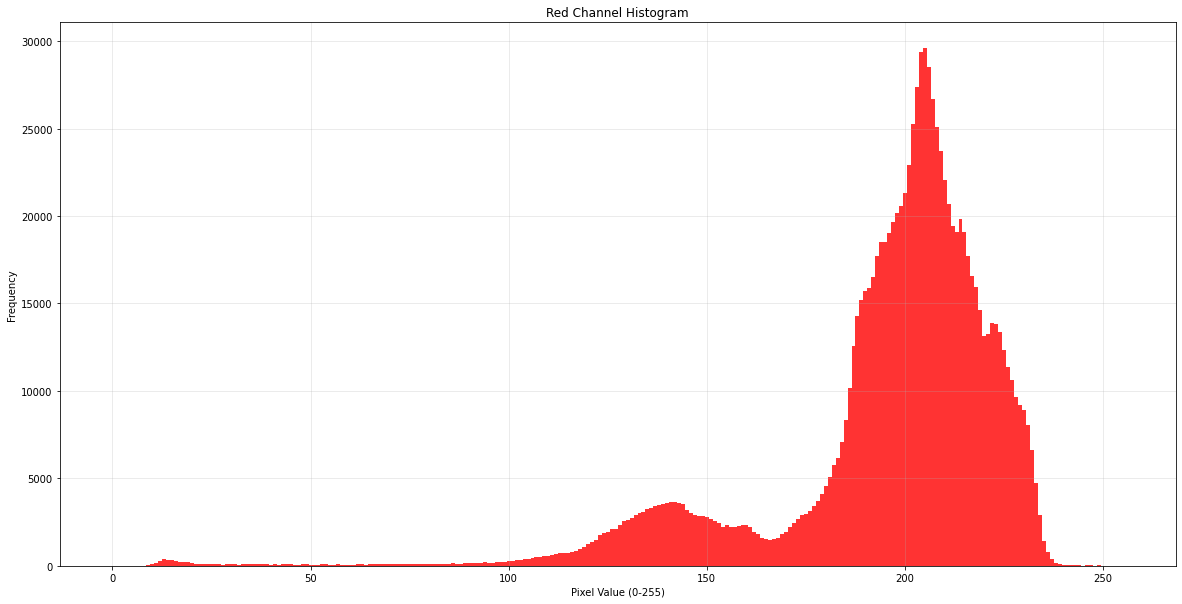

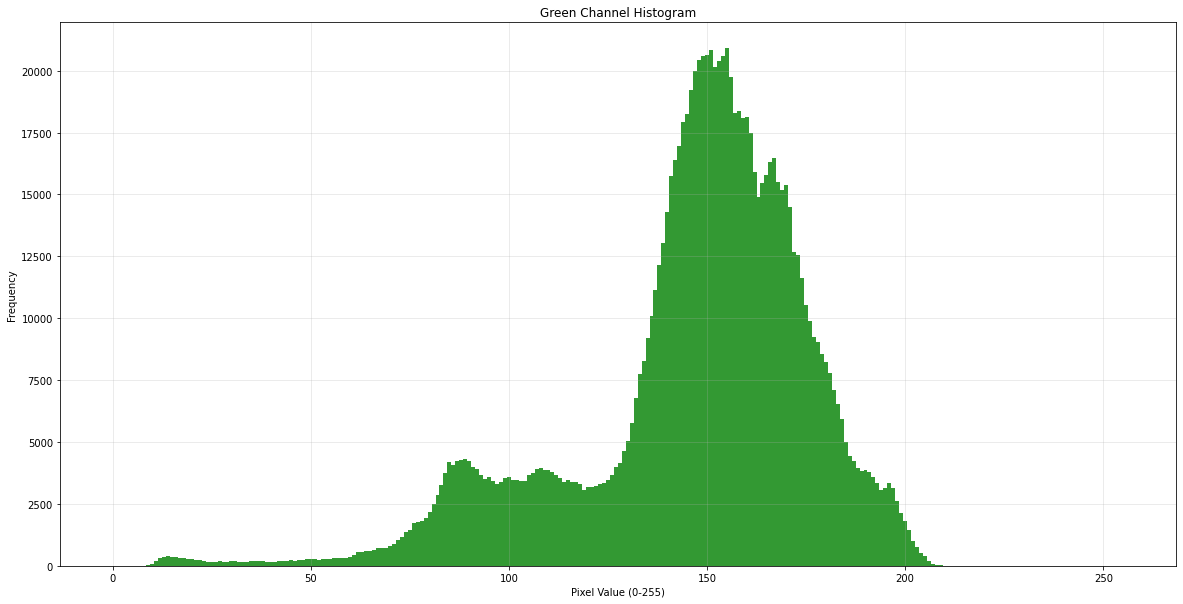

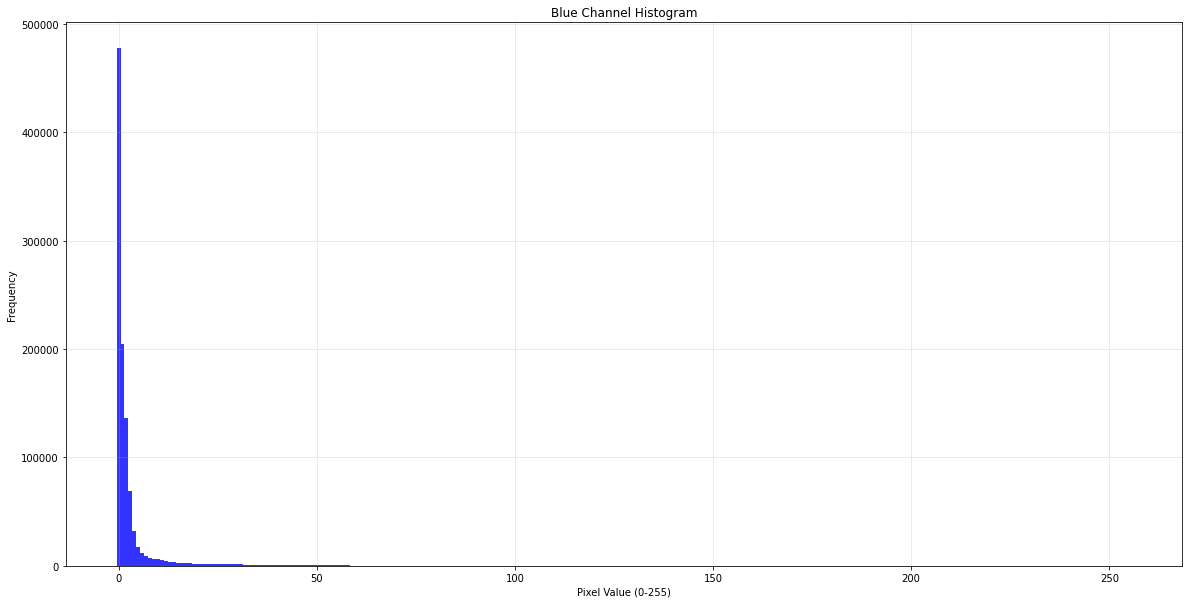

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate

dma = overlay.axi_dma_0
hist_ip = overlay.doHist_0

IMG_WIDTH = 1024
IMG_HEIGHT = 1024
BINS = 256

img = plt.imread('c.jpg')

if img.dtype == np.float32 or img.max() <= 1.0:
    img = (img * 255).astype(np.uint8)

# Separate channels
img_r = img[:,:,0]  # Red channel
img_g = img[:,:,1]  # Green channel
img_b = img[:,:,2]  # Blue channel

# Process each channel separately
for channel, name in zip([img_r, img_g, img_b], ['Red', 'Green', 'Blue']):
    input_buffer = allocate(shape=(channel.size,), dtype=np.uint8)
    output_buffer = allocate(shape=(BINS,), dtype=np.uint32)
    
    np.copyto(input_buffer, channel.flatten())
    
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    hist_ip.write(0x00, 1)
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    hist = np.copy(output_buffer)
    
    # Plot
    plt.figure(figsize=(20, 10))
    plt.bar(range(BINS), hist, color=name.lower(), width=1.0, edgecolor="none", alpha=0.8)
    plt.title(f'{name} Channel Histogram')
    plt.xlabel('Pixel Value (0-255)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    input_buffer.freebuffer()
    output_buffer.freebuffer()

In [6]:
# 256x256 greyscale
from pynq import Overlay
overlay = Overlay("histzinho.xsa")
overlay?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff55ad0f70>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay histzinho.xsa. The following
attributes are available on this overlay:

IP Blocks
----------
doHist_0             : pynq.overlay.DefaultIP
axi_dma_0            : pynq.lib.dma.DMA
zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP

Hierarchies
-----------
None

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time
protection of bindings.

Our definition of overlay is: "post-bitstream configurable design".
Hence, this class must expose configurability through content discovery
and runtime protection.

The overlay class exposes the IP and hierarchies as att

Bin values:
Bin 0: 170
Bin 1: 50
Bin 2: 45
Bin 3: 50
Bin 4: 55
Bin 5: 43
Bin 6: 42
Bin 7: 52
Bin 8: 66
Bin 9: 51
Bin 10: 66
Bin 11: 68
Bin 12: 62
Bin 13: 75
Bin 14: 70
Bin 15: 79
Bin 16: 57
Bin 17: 75
Bin 18: 72
Bin 19: 75
Bin 20: 73
Bin 21: 73
Bin 22: 74
Bin 23: 71
Bin 24: 60
Bin 25: 84
Bin 26: 73
Bin 27: 65
Bin 28: 70
Bin 29: 59
Bin 30: 80
Bin 31: 78
Bin 32: 76
Bin 33: 75
Bin 34: 79
Bin 35: 77
Bin 36: 68
Bin 37: 92
Bin 38: 73
Bin 39: 78
Bin 40: 77
Bin 41: 86
Bin 42: 82
Bin 43: 100
Bin 44: 85
Bin 45: 86
Bin 46: 69
Bin 47: 85
Bin 48: 86
Bin 49: 79
Bin 50: 72
Bin 51: 77
Bin 52: 81
Bin 53: 78
Bin 54: 78
Bin 55: 82
Bin 56: 80
Bin 57: 88
Bin 58: 78
Bin 59: 60
Bin 60: 68
Bin 61: 66
Bin 62: 88
Bin 63: 71
Bin 64: 63
Bin 65: 75
Bin 66: 80
Bin 67: 69
Bin 68: 90
Bin 69: 72
Bin 70: 85
Bin 71: 72
Bin 72: 71
Bin 73: 81
Bin 74: 81
Bin 75: 66
Bin 76: 68
Bin 77: 79
Bin 78: 71
Bin 79: 75
Bin 80: 78
Bin 81: 62
Bin 82: 72
Bin 83: 77
Bin 84: 76
Bin 85: 96
Bin 86: 71
Bin 87: 71
Bin 88: 68
Bin 89: 79
Bin 90

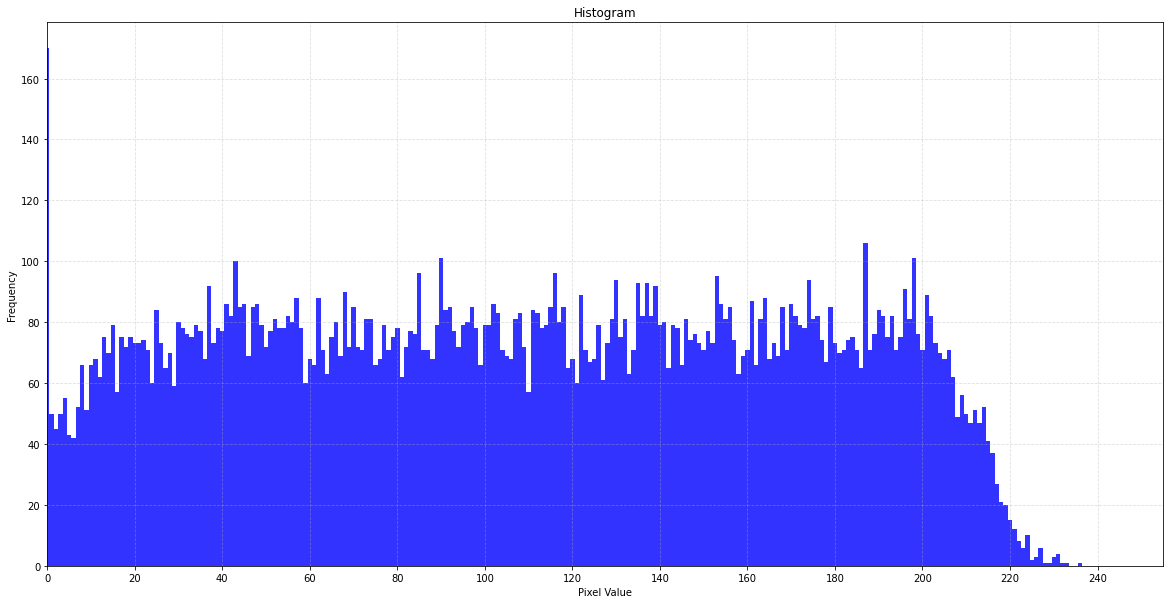

In [8]:
from pynq import allocate
import numpy as np
import cv2
import matplotlib.pyplot as plt

dma = overlay.axi_dma_0
hist_ip = overlay.doHist_0

# Constants
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_SIZE = IMG_WIDTH * IMG_HEIGHT  
BINS = 256

#img = np.arange(IMG_SIZE, dtype=np.uint8) % BINS
#img = img.reshape((IMG_HEIGHT, IMG_WIDTH))

img = cv2.imread("cat128.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))  # Resize if needed

pixel_values = img.flatten()

input_buffer = allocate(shape=(IMG_SIZE,), dtype=np.uint8)
output_buffer = allocate(shape=(BINS,), dtype=np.uint32)
    
flat_img = img.flatten()
for i in range(IMG_SIZE):
    input_buffer[i] = flat_img[i]
    
# Set up DMA transfer
dma.sendchannel.transfer(input_buffer)
dma.recvchannel.transfer(output_buffer)

hist_ip.write(0x00, 1)
    
dma.sendchannel.wait()
dma.recvchannel.wait()
    
hist = np.copy(output_buffer)
    
# Print bin values
print("Bin values:")
for i in range(BINS):
    print(f"Bin {i}: {hist[i]}")
    
plt.figure(figsize=(20, 10))
plt.bar(range(BINS), hist, color='blue', width=1.0, edgecolor="none", alpha=0.8)
plt.title('Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.xticks(np.arange(0,256,20))
plt.grid(True, linestyle='--', alpha=0.4)
plt.xlim(0, BINS-1)
plt.show()
    
input_buffer.freebuffer()
output_buffer.freebuffer()

In [17]:
#Variable histogram
from pynq import Overlay
overlay = Overlay("varHist.xsa")
overlay?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff592eb850>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay varHist.xsa. The following
attributes are available on this overlay:

IP Blocks
----------
doHist_0             : pynq.overlay.DefaultIP
axi_dma_0            : pynq.lib.dma.DMA
zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP

Hierarchies
-----------
None

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time
protection of bindings.

Our definition of overlay is: "post-bitstream configurable design".
Hence, this class must expose configurability through content discovery
and runtime protection.

The overlay class exposes the IP and hierarchies as attri

Processing 500x500 image...


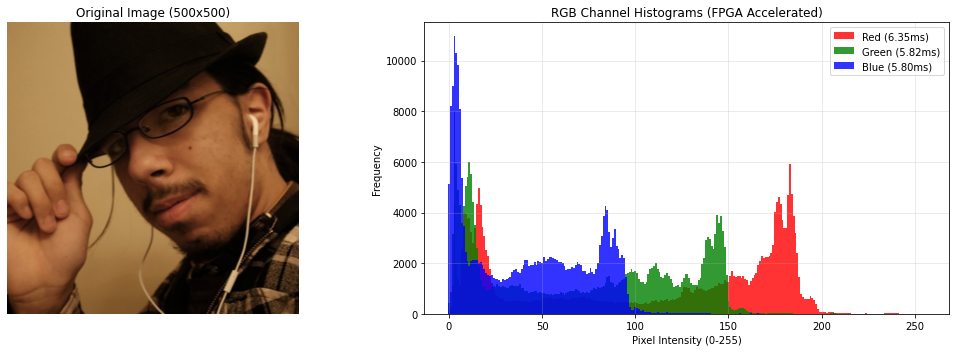


Histogram Statistics:
Red Channel:
  Max bin: 183 (count=5931)
  Min bin: 244 (count=0)
  Total pixels: 250000
Green Channel:
  Max bin: 3 (count=8025)
  Min bin: 219 (count=0)
  Total pixels: 250000
Blue Channel:
  Max bin: 3 (count=10963)
  Min bin: 177 (count=0)
  Total pixels: 250000


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import allocate, Overlay
import cv2
from time import time

dma = overlay.axi_dma_0
hist_ip = overlay.doHist_0

MAX_WIDTH = 4096
MAX_HEIGHT = 4096
BINS = 256

def compute_histogram(image_channel, width, height):
    # Verify dimensions
    if width > MAX_WIDTH or height > MAX_HEIGHT:
        raise ValueError(f"Image too large (max {MAX_WIDTH}x{MAX_HEIGHT})")
    
    input_buffer = allocate(shape=(width*height,), dtype=np.uint8)
    output_buffer = allocate(shape=(BINS,), dtype=np.uint32)
    
    np.copyto(input_buffer, image_channel.flatten())
    
    hist_ip.write(0x10, width)
    hist_ip.write(0x18, height)
    
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    
    hist_ip.write(0x00, 1)
    
    dma.sendchannel.wait()
    dma.recvchannel.wait()
    
    hist = np.copy(output_buffer)

    input_buffer.freebuffer()
    output_buffer.freebuffer()
    
    return hist

def load_and_process_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width = img.shape[:2]
    print(f"Processing {width}x{height} image...")
    
    channels = {
        'Red': img[:,:,0],
        'Green': img[:,:,1],
        'Blue': img[:,:,2]
    }
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Original Image ({width}x{height})')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    
    results = {}
    for name, channel in channels.items():
        start_time = time()
        hist = compute_histogram(channel, width, height)
        elapsed = (time() - start_time) * 1000
        results[name] = hist
        
        color = name.lower()
        plt.bar(range(BINS), hist, color=color, width=1.0, edgecolor="none", alpha=0.8, label=f'{name} ({elapsed:.2f}ms)')
    
    plt.title('RGB Channel Histograms (FPGA Accelerated)')
    plt.xlabel('Pixel Intensity (0-255)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results

image_path = 'gv.png'
hist_results = load_and_process_image(image_path)

print("\nHistogram Statistics:")
for channel, hist in hist_results.items():
    print(f"{channel} Channel:")
    print(f"  Max bin: {np.argmax(hist)} (count={np.max(hist)})")
    print(f"  Min bin: {np.argmin(hist)} (count={np.min(hist)})")
    print(f"  Total pixels: {np.sum(hist)}")

In [14]:
#Variable Histogram RGB in HW
from pynq import Overlay
overlay = Overlay("rvarHist1.xsa")
overlay?

Type:            Overlay
String form:     <pynq.overlay.Overlay object at 0xffff597f4cd0>
File:            /usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py
Docstring:      
Default documentation for overlay rvarHist1.xsa. The following
attributes are available on this overlay:

IP Blocks
----------
axi_dma_0            : pynq.lib.dma.DMA
rgb_histogram_0      : pynq.overlay.DefaultIP
zynq_ultra_ps_e_0    : pynq.overlay.DefaultIP

Hierarchies
-----------
None

Interrupts
----------
None

GPIO Outputs
------------
None

Memories
------------
PSDDR                : Memory
Class docstring:
This class keeps track of a single bitstream's state and contents.

The overlay class holds the state of the bitstream and enables run-time
protection of bindings.

Our definition of overlay is: "post-bitstream configurable design".
Hence, this class must expose configurability through content discovery
and runtime protection.

The overlay class exposes the IP and hierarchies as att

Starting image processing...
Loading FPGA overlay...
Loading image...
Computing histograms...
Generating visualization...


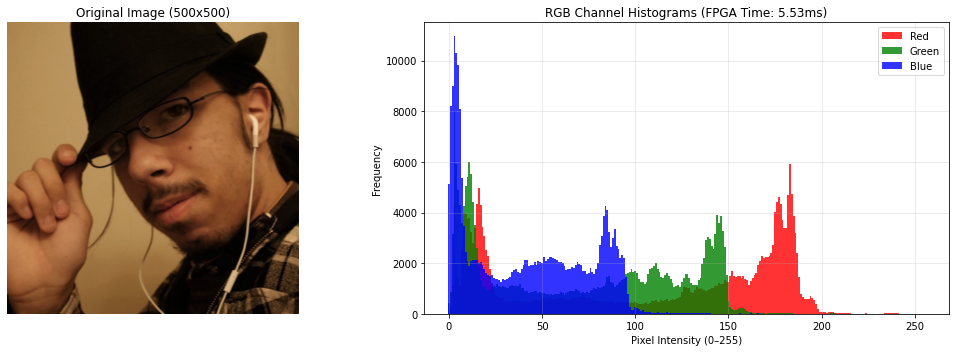


Histogram Statistics:
Red Channel:
  Max bin: 183 (count=5931)
  Min bin: 244 (count=0)
  Total pixels: 250000
Green Channel:
  Max bin: 3 (count=8025)
  Min bin: 219 (count=0)
  Total pixels: 250000
Blue Channel:
  Max bin: 3 (count=10963)
  Min bin: 177 (count=0)
  Total pixels: 250000
Resources released
Processing complete


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import Overlay, allocate
import cv2
from time import time
from matplotlib.gridspec import GridSpec

def process_image(image_path):
    overlay = None
    in_buf, out_buf = None, None
    
    try:
        # Constants
        MAX_WIDTH = 4096
        MAX_HEIGHT = 4096
        BINS = 256

        print("Loading FPGA overlay...")
        overlay = Overlay('rvarHist1.xsa')
        dma = overlay.axi_dma_0
        hist_ip = overlay.rgb_histogram_0

        print("Loading image...")
        img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        if img is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        h, w = img.shape[:2]
        if h > MAX_HEIGHT or w > MAX_WIDTH:
            img = cv2.resize(img, (MAX_WIDTH, MAX_HEIGHT))
            h, w = img.shape[:2]

        print("Computing histograms...")
        
        in_buf = allocate((h,w), np.uint32)
        out_buf = allocate(3*BINS, np.uint32)
        
        rgb_packed = ((img[:,:,0].astype(np.uint32) << 16) | 
                     (img[:,:,1].astype(np.uint32) << 8) | 
                      img[:,:,2].astype(np.uint32))
        np.copyto(in_buf, rgb_packed)
        
        hist_ip.write(0x10, w)
        hist_ip.write(0x18, h)
        
        start_time = time()
        dma.sendchannel.transfer(in_buf)
        dma.recvchannel.transfer(out_buf)
        hist_ip.write(0x00, 1)
        
        dma.sendchannel.wait()
        dma.recvchannel.wait()
        fpga_time = (time() - start_time) * 1000
        
        hist_r = out_buf[:BINS]
        hist_g = out_buf[BINS:2*BINS]
        hist_b = out_buf[2*BINS:3*BINS]

        print("Generating visualization...")
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Original Image ({w}x{h})')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.bar(range(BINS), hist_r, color='red', alpha=0.8, width=1.0, edgecolor="none", label='Red')
        plt.bar(range(BINS), hist_g, color='green', alpha=0.8, width=1.0, edgecolor="none", label='Green')
        plt.bar(range(BINS), hist_b, color='blue', alpha=0.8, width=1.0, edgecolor="none", label='Blue')
        plt.title(f'RGB Channel Histograms (FPGA Time: {fpga_time:.2f}ms)')
        plt.xlabel('Pixel Intensity (0–255)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\nHistogram Statistics:")
        print(f"Red Channel:\n  Max bin: {np.argmax(hist_r)} (count={np.max(hist_r)})\n  Min bin: {np.argmin(hist_r)} (count={np.min(hist_r)})\n  Total pixels: {np.sum(hist_r)}")
        print(f"Green Channel:\n  Max bin: {np.argmax(hist_g)} (count={np.max(hist_g)})\n  Min bin: {np.argmin(hist_g)} (count={np.min(hist_g)})\n  Total pixels: {np.sum(hist_g)}")
        print(f"Blue Channel:\n  Max bin: {np.argmax(hist_b)} (count={np.max(hist_b)})\n  Min bin: {np.argmin(hist_b)} (count={np.min(hist_b)})\n  Total pixels: {np.sum(hist_b)}")

    except Exception as e:
        print(f"Error: {str(e)}")
    finally:
        if in_buf is not None:
            in_buf.freebuffer()
        if out_buf is not None:
            out_buf.freebuffer()
        if overlay is not None:
            del overlay
        print("Resources released")

print("Starting image processing...")
process_image('gv.png')
print("Processing complete")